In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import cvxpy as cp
import gurobipy
import mosek

from src.problem import Problem
from src.coco import CoCo
from src.gp import GaussianProcess
from pytorch.models import FFNet

np.random.seed(12)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import math
import seaborn as sns
sns.set(font_scale=2., font="serif", style="whitegrid")
import pandas as pd
import matplotlib

mpl_params = {
#     'backend': 'ps',
#               'text.latex.preamble': ['\\usepackage{gensymb}'],
#               'axes.labelsize': 12, # fontsize for x and y labels (was 12 and before 10)
#               'axes.titlesize': 12,
#               'font.size': 12, # was 12 and before 10
              'legend.fontsize': 16, # was 12 and before 10
#               'xtick.labelsize': 12,
#               'ytick.labelsize': 12,
#               'text.usetex': True,
#               'font.family': 'serif',
#               'font.sans-serif':['Helvetica Neue']
    }

sns.set(font_scale=2.5)
matplotlib.rcParams.update(mpl_params)

#### The time series from CAISO has 288 data points, so we can choose the resolution at which we sample it and the size of the MICP.

In [4]:
dh_s = 120*60
initial_storage_MW = 0.0
max_storage_MW = 100e3

n_files = 5
n_sources = 12
max_sources = 8

N = 12
Ts = []
for ii in range(0,288, int(np.floor(288/N))):
    Ts.append(ii)
Ts = np.atleast_2d(Ts).T

In [5]:
x_train = np.reshape(np.repeat(Ts, (n_files), axis=1).T, (n_files*N,1))
supply_train = np.zeros((n_sources, n_files*N))
demand_train = np.zeros(n_files*N)

for ii in range(n_files):
    str_ii = str(ii+1).zfill(2)
    supply_df = pd.read_csv('data/CAISO-supply-2021{}20.csv'.format(str_ii))
    demand_df = pd.read_csv('data/CAISO-demand-2021{}20.csv'.format(str_ii))
    renewables_df = pd.read_csv('data/CAISO-renewables-2021{}20.csv'.format(str_ii))

    natural_gas = supply_df.iloc[1].values[1:-1][Ts]
    large_hydro = supply_df.iloc[2].values[1:-1][Ts]
    imports = supply_df.iloc[3].values[1:-1][Ts]
    batteries = supply_df.iloc[4].values[1:-1][Ts]
    nuclear = supply_df.iloc[5].values[1:-1][Ts]
    coal = supply_df.iloc[6].values[1:-1][Ts]
#     other = supply_df.iloc[7].values[1:-1][Ts]

    solar = renewables_df.iloc[0].values[1:][Ts]
    wind = renewables_df.iloc[1].values[1:][Ts]
    geothermal = renewables_df.iloc[2].values[1:][Ts]
    biomass = renewables_df.iloc[3].values[1:][Ts]
    biogas = renewables_df.iloc[4].values[1:][Ts]
    small_hydro = renewables_df.iloc[5].values[1:][Ts]

    hour_ahead_forecast = demand_df.iloc[1].values[1:-1][Ts]

    idx_range = range(N*ii, N*(ii+1))
    supply_train[0, idx_range] = solar.flatten()
    supply_train[1, idx_range] = wind.flatten()
    supply_train[2, idx_range] = wind.flatten()
    supply_train[3, idx_range] = biomass.flatten()
    supply_train[4, idx_range] = biogas.flatten()
    supply_train[5, idx_range] = small_hydro.flatten()
    supply_train[6, idx_range] = natural_gas.flatten()
    supply_train[7, idx_range] = large_hydro.flatten()
    supply_train[8, idx_range] = imports.flatten()
    supply_train[9, idx_range] = batteries.flatten()
    supply_train[10, idx_range] = nuclear.flatten()
    supply_train[11, idx_range] = coal.flatten()

    demand_train[idx_range] = hour_ahead_forecast.flatten()

### Construct GPs for energy sources

In [6]:
supply_gps = []
εs = 1e3*np.ones(n_sources)

εs = [1e3, 1e3, 1e3, 1e1, 1e1, 3e1, 1e3, 1e3, 1e3, 1e2, 1e2, 5]
εs = [1e3, 1e3, 1e3, 1e-1, 5.0, 3e1, 1e3, 1e3, 1e3, 1e2, 1e2, 5]

for ii in range(n_sources):
    gp = GaussianProcess()
    gp.train(x_train, supply_train[ii,:])
    gp.predict(Ts, ε=εs[ii])
    supply_gps.append(gp)

(170.0, 230.0)

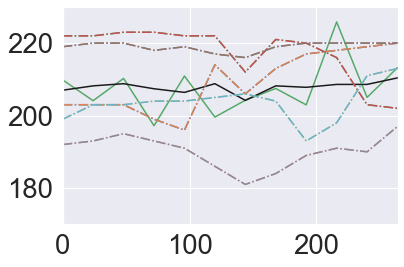

In [7]:
kk = 4
gp = supply_gps[kk]
plt.plot(Ts, gp.sample(), linestyle='-', color='g')
plt.plot(Ts, gp.mean, linestyle='-', color='k')
for ii in range(n_files):
    idx_range = range(N*ii,N*(ii+1))
    plt.plot(Ts, supply_train[kk,idx_range], linestyle='-.')
    ax = sns.lineplot(x=Ts.flatten(), y=supply_train[kk,idx_range].flatten(), linestyle='-.')
plt.xlim([0, Ts[-1]]);
plt.ylim([170, 230])

### Construct GP for demand

Text(0, 0.5, 'Demand [MW]')

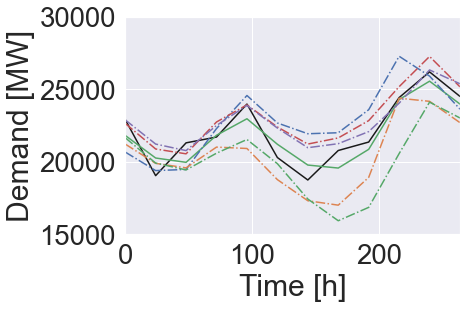

In [8]:
demand_gp = GaussianProcess()
demand_gp.train(x_train, demand_train)
demand_gp.predict(Ts, ε=1e3)

plt.plot(Ts, demand_gp.sample(), linestyle='-', color='k')
plt.plot(Ts, demand_gp.mean, linestyle='-', color='g')
for ii in range(n_files):
    idx_range = range(N*ii,N*(ii+1))
    ax = plt.plot(Ts, demand_train[idx_range], linestyle='-.')

plt.xlim([0, Ts[-1]])
plt.ylim([15000, 30000])
plt.xlabel("Time [h]")
plt.ylabel("Demand [MW]")

# matplotlib.pyplot.savefig('figs/demand_gp.png')

### Solve sample problem

In [9]:
supply = np.zeros((n_sources, N))
for ii, gp in enumerate(supply_gps):
    supply[ii] = gp.sample()
supply = np.maximum(supply, 0.0)

hour_ahead_forecast = demand_gp.sample()

params = {}
params['initial_storage_MW'] = initial_storage_MW
params['max_sources'] = max_sources
params['supply'] = supply
params['hour_ahead_forecast'] = hour_ahead_forecast

prob_features = []
for kk in params:
    prob_features.append(kk)

In [11]:
prob = Problem(N, n_sources)

In [12]:
prob_success, cost, solve_time, optvals = prob.solve_bin_problem(params, solver=cp.GUROBI)
print(cost)
print(solve_time)

Academic license - for non-commercial use only - expires 2021-08-01
Using license file /home/acauligi/licenses/gurobi.lic
360035.5320802506
0.011921882629394531


In [13]:
prob_success, cost, solve_time, optvals = prob.solve_bin_problem(params, solver=cp.MOSEK)
print(cost)
print(solve_time)

360053.23326272855
1.5283570289611816


In [15]:
y_opt = np.round(optvals[0])
prob.solve_coco_problem(params, y_opt, solver=cp.GUROBI)

(True, 360035.53208028834, 0.0007410049438476562)

### Generate training dataset

In [16]:
num_train = 900
prob = Problem(N, n_sources)

params = {}
for kk in prob.bin_prob_params:
    params[kk] = []
Y = np.zeros((num_train, prob.n_sources, prob.N))
costs = np.zeros(num_train)
solve_times = np.zeros(num_train)

prob_ii = 0
while prob_ii < num_train:
    supply = np.zeros((n_sources, N))
    for ii, gp in enumerate(supply_gps):
        supply[ii] = gp.sample()
    supply = np.maximum(supply, 0.0)

    hour_ahead_forecast = demand_gp.sample()

    prob_params = {}
    prob_params['initial_storage_MW'] = initial_storage_MW
    prob_params['max_sources'] = max_sources
    prob_params['supply'] = supply
    prob_params['hour_ahead_forecast'] = hour_ahead_forecast

    prob_success, cost, solve_time, optvals = prob.solve_bin_problem(prob_params, solver=cp.GUROBI)

    if prob_success:
        y_opt = optvals[0]
        costs[prob_ii] = cost
        solve_times[prob_ii] = solve_time
        Y[prob_ii] = y_opt
        for kk in prob_params:
            params[kk].append(prob_params[kk])
        prob_ii += 1

/home/acauligi/energy_291/energy291-project/energy291_project/lib/python3.6/site-packages/cvxpy/problems/problem.py:1268: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


### Train CoCo

In [17]:
system = "energy"

prob = Problem(N, n_sources)
coco = CoCo(system, prob, prob_features)

In [18]:
train_data = [params, Y]

n_features = 1 + 1 + prob.n_sources*prob.N + prob.N
coco.construct_strategies(n_features, train_data)

coco.setup_network(device_id=-1)
print(coco.n_strategies)
coco.model

896


FFNet(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=158, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=896, bias=True)
  )
)

In [19]:
coco.training_params['TRAINING_ITERATIONS'] = 100
coco.train(verbose=False)

Saved model at /home/acauligi/energy_291/energy291-project/CoCo_energy_20210603_1621.pt
Done training


### Evaluate CoCo

In [20]:
supply = np.zeros((n_sources, N))
for ii, gp in enumerate(supply_gps):
    supply[ii] = gp.sample()
supply = np.maximum(supply, 0.0)
hour_ahead_forecast = demand_gp.sample()

prob_params = {}
prob_params['initial_storage_MW'] = initial_storage_MW
prob_params['max_sources'] = max_sources
prob_params['supply'] = supply
prob_params['hour_ahead_forecast'] = hour_ahead_forecast

prob_success, true_cost, ip_solve_time, optvals = prob.solve_bin_problem(prob_params, solver=cp.MOSEK)
total_time = np.Inf
prob_success, cost, total_time, n_evals = coco.forward(prob_params, solver=cp.MOSEK)
print(ip_solve_time)
print(total_time)

7.354007005691528
0.0070421695709228516


In [27]:
n_test = 1000

n_succ = 0
count = 0

costs_coco = []
total_time_coco = []
num_solves_coco = []

cost_ratios_coco = []
costs_ip = []
total_time_ip = []
num_solves_ip = []

for ii in range(n_test):
    if ii % 10 == 0 and ii > 0:
        print('Done with {} problems\n'.format(count))
    supply = np.zeros((n_sources, N))
    for ii, gp in enumerate(supply_gps):
        supply[ii] = gp.sample()
    supply = np.maximum(supply, 0.0)
    hour_ahead_forecast = demand_gp.sample()

    prob_params = {}
    prob_params['initial_storage_MW'] = initial_storage_MW
    prob_params['max_sources'] = max_sources
    prob_params['supply'] = supply
    prob_params['hour_ahead_forecast'] = hour_ahead_forecast

    try:
        prob_success, true_cost, ip_solve_time, optvals = prob.solve_bin_problem(prob_params, solver=cp.MOSEK)
        if not prob_success:
            continue

        prob_success, cost, total_time, n_evals = coco.forward(prob_params, solver=cp.MOSEK)

        count += 1
        if prob_success:
            n_succ += 1
            costs_coco += [cost]
            total_time_coco += [total_time]
            num_solves_coco += [n_evals]

            costs_ip += [true_cost]
            total_time_ip += [ip_solve_time]

            cost_ratios_coco += [cost / true_cost]
    except (KeyboardInterrupt, SystemExit):
        raise
    except:
        print('Solver failed at {}'.format(ii))
        continue

costs_coco = np.array(costs_coco)
cost_ratios_coco = np.array(cost_ratios_coco)
total_time_coco = np.array(total_time_coco)
num_solves_coco = np.array(num_solves_coco, dtype=int)

costs_ip = np.array(costs_ip)
total_time_ip = np.array(total_time_ip)
num_solves_ip = np.array(num_solves_ip, dtype=int)

coco_percentage = 100 * float(n_succ) / float(count)
coco_percentage

Done with 10 problems

Done with 20 problems

Done with 29 problems

Done with 39 problems

Done with 49 problems

Done with 59 problems

Done with 69 problems

Done with 78 problems

Done with 88 problems

Done with 98 problems

Done with 104 problems

Done with 113 problems

Done with 123 problems

Done with 132 problems

Done with 140 problems

Done with 150 problems

Done with 160 problems

Done with 170 problems

Done with 180 problems

Done with 190 problems

Done with 200 problems

Done with 210 problems

Done with 218 problems

Done with 228 problems

Done with 238 problems

Done with 246 problems

Done with 256 problems

Done with 266 problems

Done with 275 problems

Done with 284 problems

Done with 293 problems

Done with 302 problems

Done with 312 problems

Done with 321 problems

Done with 331 problems

Done with 341 problems

Done with 351 problems

Done with 361 problems

Done with 370 problems

Done with 379 problems

Done with 388 problems

Done with 396 problems

Do

99.15611814345992

In [28]:
coco_percentage

99.15611814345992

### Plot results

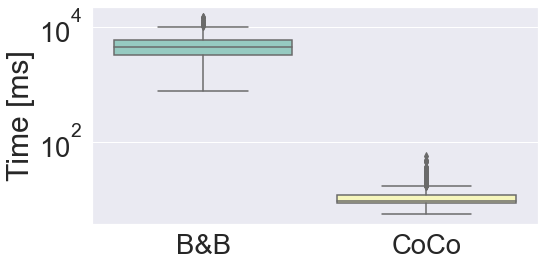

In [29]:
results = {}
results['Policy'] = ['B&B']*len(total_time_ip) + ['CoCo']*len(total_time_coco)
results['Time'] = 1000*np.hstack((total_time_ip, total_time_coco))
results = pd.DataFrame(results)

plt.figure(figsize=(8,4))
plt.tight_layout()

ax_time = sns.boxplot(x=results['Policy'], y=results['Time'], palette="Set3")
ax_time.set(xlabel="", ylabel="Time [ms]")
ax_time.set_yscale("log")

figure = ax_time.get_figure()
# figure.savefig("figs/time.png", bbox_inches='tight')

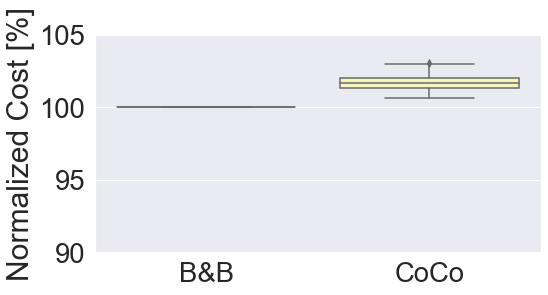

In [23]:
results = {}
results['Policy'] =  ['B&B']*len(costs_ip) + ['CoCo']*len(cost_ratios_coco)
results['Optimality'] = np.hstack(([100]*costs_ip.size, 100*cost_ratios_coco))
results = pd.DataFrame(results)

plt.figure(figsize=(8,4))
plt.tight_layout()
plt.ylim([90, 105])

ax_cost = sns.boxplot(x=results['Policy'], y=results['Optimality'], palette="Set3")
ax_cost.set(xlabel="", ylabel="Normalized Cost [%]")

figure = ax_cost.get_figure()
# figure.savefig("figs/cost.png", bbox_inches='tight')

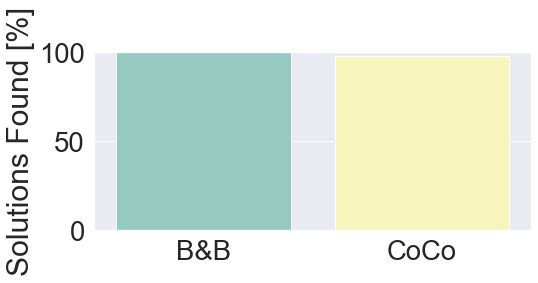

In [24]:
results = {}
results = {'B&B':[100.0], 'CoCo':[coco_percentage]}
results = pd.DataFrame(results)

plt.figure(figsize=(8,4))
plt.ylim(0,100)
plt.tight_layout()

ax_success = sns.barplot(data=results, palette="Set3")
ax_success.set(xlabel="", ylabel="Solutions Found [%]")

figure = ax_success.get_figure()
# figure.savefig("figs/percent_success.png", bbox_inches='tight')

In [25]:
coco_percentage

97.87234042553192